In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
from numpy import where

import pickle

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from imblearn.over_sampling import RandomOverSampler as ros
from imblearn.under_sampling import RandomUnderSampler as rus
from imblearn.over_sampling import SMOTE

In [2]:
cols = ['Loan Identifier', 'Monthly Reporting Period', 'Origination Date', 'Maturity Date']
df = pd.read_csv('../Final_Clean_Data.csv', index_col=0).drop(cols, axis=1)

In [3]:
df.head()

,Current Interest Rate,Original UPB,Original Loan Term,Loan Age,Original Loan to Value Ratio (LTV),Number of Borrowers,Debt-To-Income (DTI),First Time Home Buyer Indicator,Modification Flag,Home Ready Program Indicator,High Balance Loan Indicator,Minimum Credit Score,Foreclosed
0,3.750,65000,360,59,74,1,31,0,0,0,0,814,0
1,4.000,153000,360,58,95,2,17,0,0,0,0,788,0
2,3.625,114000,360,54,95,2,37,1,0,0,0,745,0
3,3.875,150000,360,56,70,2,16,0,0,0,0,810,0
4,4.250,40000,360,59,24,2,36,0,0,0,0,755,0


In [4]:
# # define dataset
X = df[['Current Interest Rate', 'Original UPB', 'Original Loan Term',
       'Loan Age', 'Original Loan to Value Ratio (LTV)', 'Number of Borrowers',
       'Debt-To-Income (DTI)', 'First Time Home Buyer Indicator',
       'Modification Flag', 'Home Ready Program Indicator',
       'High Balance Loan Indicator', 'Minimum Credit Score']
]

y = df['Foreclosed']

In [5]:
# summarize class distribution
counter = Counter(y)
print(counter)

Counter({0: 8255841, 1: 22816})


In [6]:
X_array = df[['Current Interest Rate', 'Original UPB', 'Original Loan Term',
       'Loan Age', 'Original Loan to Value Ratio (LTV)', 'Number of Borrowers',
       'Debt-To-Income (DTI)', 'First Time Home Buyer Indicator',
       'Modification Flag', 'Home Ready Program Indicator',
       'High Balance Loan Indicator', 'Minimum Credit Score']].to_numpy()

y_array = df['Foreclosed'].to_numpy()

Counter({0: 8255841, 1: 22816})


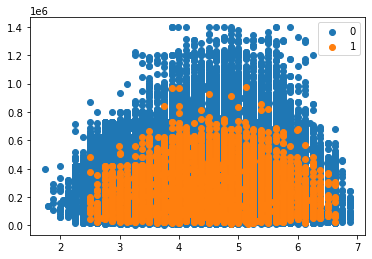

In [9]:
# Generate and plot a synthetic imbalanced classification dataset
from collections import Counter
from numpy import where

# summarize class distribution
counter = Counter(y_array)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = where(y_array == label)[0]
    plt.scatter(X_array[row_ix, 0], X_array[row_ix, 1], label=str(label))
plt.legend()
plt.show()

In [6]:
# example of random oversampling to balance the class distribution
# Combining Random Oversampling and Undersampling

# summarize class distribution
print(Counter(y))

# define undersampling strategy
under = rus(sampling_strategy=0.5)
# fit and apply the transform
X_under, y_under = under.fit_resample(X, y)
# summarize class distribution
print(Counter(y_under))

# define oversampling strategy
over = SMOTE(sampling_strategy=0.7)
# fit and apply the transform
X_over, y_over = over.fit_resample(X_under, y_under)
# summarize class distribution
print(Counter(y_over))

Counter({0: 8255841, 1: 22816})
Counter({0: 45632, 1: 22816})
Counter({0: 45632, 1: 31942})


In [7]:
#Using the train_test_split to create train and test sets.
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X_over, y_over, random_state = 42, test_size = 0.10)

In [8]:
#Using the train_test_split to create train and test sets.
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X_under, y_under, random_state = 42, test_size = 0.10)

In [13]:
 params = {
        'min_child_weight': [0.2, 0.5, 1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5, 6],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 6]
        }

# define model
model = XGBClassifier(tree_method='gpu_hist', gpu_id=0)
# define grid
# weights = [0.2, 0.5, 1, 10, 50. 100]
# param_grid = dict(scale_pos_weight=weights)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=params, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X_over, y_over)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

[13:52:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best: 0.856383 using {'colsample_bytree': 1.0, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 0.2, 'subsample': 1.0}
0.851563 (0.004703) with: {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 0.2, 'subsample': 0.6}
0.852375 (0.004387) with: {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 0.2, 'subsample': 0.8}
0.853285 (0.004525) with: {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 0.2, 'subsample': 1.0}
0.851600 (0.004721) with: {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 0.5, 'subsample': 0.6}
0.852598 (0.004372) with: {'colsample_bytree': 0.6, 'gamma': 0.5, 'max

In [9]:
# {'colsample_bytree': 1.0, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 0.2, 'subsample': 1.0}

In [10]:
# fit model on training data
model_xgb_over = XGBClassifier(eval_metric='mlogloss',
                             
                               colsample_bytree= 1.0, 
                               gamma=0.5, 
                               max_depth=4, 
                               min_child_weight=0.2,
                              subsample=1.0)
model_xgb_over.fit(X_train_o, y_train_o)

# make predictions for test data
predictions = model_xgb_over.predict(X_test_o)

print(model_xgb_over)

# evaluate predictions
accuracy = accuracy_score(y_test_o, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, eval_metric='mlogloss',
              gamma=0.5, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=4, min_child_weight=0.2, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1.0, tree_method='exact',
              validate_parameters=1, verbosity=None)
Accuracy: 77.87%


In [11]:
# save the model to disk
filename = '../Models/model_xgb_over.sav'
pickle.dump(model_xgb_over, open(filename, 'wb'))

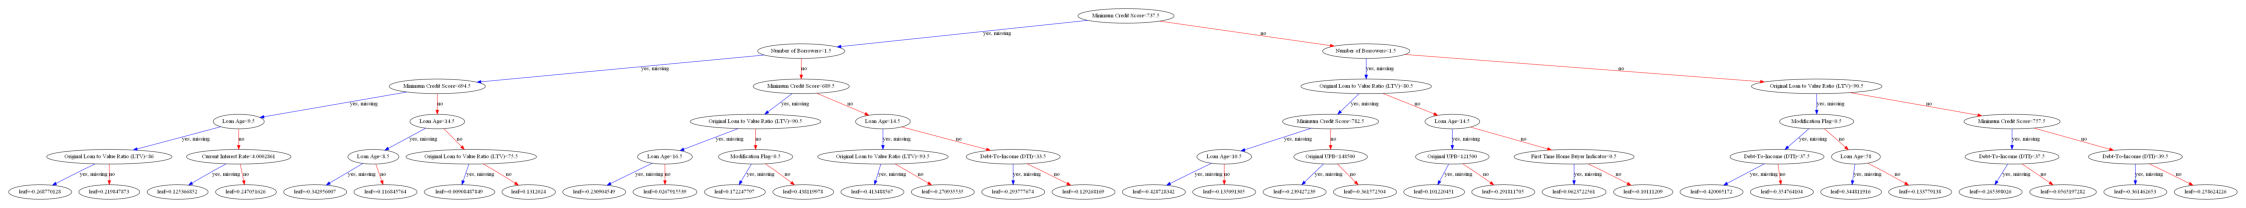

In [46]:
%matplotlib inline
from xgboost import plot_tree


plot_tree(model_xgb_over, num_trees=1)
fig = plt.gcf()
fig.set_size_inches(40, 20)
plt.savefig("../Notebook_images/treeplot")

In [12]:
# fit model on training data
model_xgb_under = XGBClassifier(colsample_bytree= 1.0, 
                               gamma=0.5, 
                               max_depth=5, 
                               min_child_weight=0.2,
                              subsample=1.0)
model_xgb_under.fit(X_train_u, y_train_u)

# make predictions for test data
predictions = model_xgb_under.predict(X_test_u)

print(model_xgb_under)

# evaluate predictions
accuracy = accuracy_score(y_test_u, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[08:35:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=0.2, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
              tree_method='exact', validate_parameters=1, verbosity=None)
Accuracy: 74.96%


In [13]:
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# print(classification_report(y_test_xgb_o, predictions))
# df_matrix=pd.DataFrame(confusion_matrix(y_test_xgb_o, predictions), 
#              columns=["Predicted False", "Predicted True"], 
#              index=["Actual False", "Actual True"])
# df_matrix.style.background_gradient(cmap='Blues')

Accuracy: 74.96%
